## Sentiment Analysis for Online Reviews

In [1]:
# libraries to import
import string
import math
import pandas as pd
import numpy as np
import nltk as nltk
import scipy as sp
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer  
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\simir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### a) Downloading, reading and analyzing datasets

In [2]:
# load data in the right> format according to readme files
yelp=pd.read_csv("sentiment_labelled_sentences\yelp_labelled.txt",delimiter="\t", names=["Sentence", "Label"])
imdb=pd.read_csv("sentiment_labelled_sentences\imdb_labelled.txt",delimiter="\t", names=["Sentence", "Label"])
amazon=pd.read_csv("sentiment_labelled_sentences\labelled_amazon.txt",delimiter="\t", names=["Sentence", "Label"])

In [3]:
# check if data is balance in all three dataframes

# yelp
ones_yelp = len(yelp[yelp['Label'] == 1])
zeros_yelp = len(yelp[yelp['Label'] == 0])
print('Number of 1s in Yelp:', ones_yelp)
print('Number of 0s in Yelp:', zeros_yelp)

#imdb
ones_imdb = len(imdb[imdb['Label'] == 1])
zeros_imdb = len(imdb[imdb['Label'] == 0])
print('Number of 1s in Imdb:', ones_imdb)
print('Number of 0s in Imdb:', zeros_imdb)

#amazon
ones_amazon = len(amazon[amazon['Label'] == 1])
zeros_amazon = len(amazon[amazon['Label'] == 0])
print('Number of 1s in Amazon:', ones_amazon)
print('Number of 0s in Amazon:', zeros_amazon)

Number of 1s in Yelp: 500
Number of 0s in Yelp: 500
Number of 1s in Imdb: 386
Number of 0s in Imdb: 362
Number of 1s in Amazon: 500
Number of 0s in Amazon: 500


The data in the Yelp and Amazon files is balanced because there are the same number of 1s and 0s as labels. 
The data in the Imdb file can be considered almost balancen because the number of 1s and 0s is almost the same (386 and 362, respectively). The ratio of 1s to 0s is 386/362 = 1.067.

#### b) Pre-processing datasets

In [4]:
def preprocessing(data):
    stop_words = set(stopwords.words('english')) # find stop words in English language
    lemmatizer = WordNetLemmatizer() # declare nltk lemmatizer

    # iterate through every sentence and replace it by itself lemmatized, without punctuation and without stop words
    for i in data['Sentence'].index:
    
        # remove punctuation
        sentence_no_punct = ''
        for char in (data.at[i, 'Sentence']):
            if char not in string.punctuation:
                sentence_no_punct = sentence_no_punct + char
        (data.at[i, 'Sentence']) = sentence_no_punct

        word_tokens = word_tokenize(data.at[i, 'Sentence'])
        # remove stop words and lemmatize
        word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words]
        word_tokens = [lemmatizer.lemmatize(word, 'v') for word in word_tokens]
        word_tokens = [lemmatizer.lemmatize(word, 'a') for word in word_tokens]
        # remove conjunction words
        word_tokens = [word for word in word_tokens if word[-2:] != 'nt']
        (data.at[i, 'Sentence']) = ' '.join(word_tokens)
        
    return data

In [5]:
# convert all letters to lower case
yelp = yelp.applymap(lambda s:s.lower() if type(s) == str else s)
imdb = imdb.applymap(lambda s:s.lower() if type(s) == str else s)
amazon = amazon.applymap(lambda s:s.lower() if type(s) == str else s)

# lemmatize, remove punctuation, remove stop words
preprocessing(yelp)
preprocessing(imdb)
preprocessing(amazon);

For this part, we decided to convert all sentences to lower case, so that the same word with some upper case letters and without them would not be detected as different words since we are using the string type which takes into account their differences. 

We also stripped the sentences of stop words because they do not add any meaning as the same stop words appear in many different sentences.

Additionally, we removed the punctuation because it does not add any meaning to the word analysis exercise we will do in this question. 

We also lemmatized all the words because we are interested in knowing which class of words they belong to in order to understand the meaning of the sentence and not whether they are a noun, adjective, etc.

We finally removed words with the conjunction "n't" because these are also meaningless words like "isn't" and "didn't". They are basically stop words but are not caught by the stop word checker because of the extra "n't".

#### c) Split training and testing data

In [6]:
# split the three datasets into training and testing data according to the specifications

def split_data(data):
    data.reset_index(drop=True)
    training = (data.query('Label == 1' )).head(400).append((data.query('Label == 0' )).head(400))
    testing = (data.query('Label == 1' )).tail(100).append((data.query('Label == 0' )).tail(100))
    return training, testing

In [7]:
# split yelp
training_yelp, testing_yelp = split_data(yelp)

# split imdb
training_imdb, testing_imdb = split_data(imdb)

# split amazon
training_amazon, testing_amazon = split_data(amazon)

In [8]:
# concatenate training and testing data for all files
train_data = training_yelp.append(training_imdb, ignore_index=True).append(training_amazon, ignore_index=True)
print(np.shape(train_data)) # this not exactly 2400? Because IMDB does not reach 800 data points...but why

test_data = testing_yelp.append(testing_imdb, ignore_index=True).append(testing_amazon, ignore_index=True)
print(np.shape(test_data)) 

(2348, 2)
(600, 2)


#### d) Bag of Words model

For this question we cannot use the testing set to create the dictionary of unique words because the model needs to be created with the training set so that we can use the testing set as new data to test our model's ability to generalize. If we create the dictionary with the testing data, we are esentially using all the data as training data and would need to look for another set of new data to test the classifier.

In [9]:
# create set of unique words in training set
word_dictionary = {}

# iterate through every word or every sentence and store it in dictionary with count 0 (the count will be updated
# later when we iterate through both testing and training set
for i in train_data.index:
    word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
    for word in word_tokens_training:
        word_dictionary[word] = 0
        
# count the number of occurences of each word in dictionary in training set
for i in train_data.index:
    word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
    for word in word_tokens_training:
        if word in word_dictionary:
            word_dictionary[word] += 1
            
# count the number of occurences of each word in dictionary in testing set  
for i in test_data.index:
    word_tokens_testing = word_tokenize(test_data.at[i, 'Sentence'])
    for word in word_tokens_testing:
        if word in word_dictionary:
            word_dictionary[word] += 1

# create one feature vector per review
feature_column = [] # list to store the feature vectors and add to dataframe at the end
for i in train_data.index:
    word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
    feature_vector = np.zeros(len(word_dictionary.keys())) # to store feature vector in each iteration
    for j, dict_word in enumerate(word_dictionary.keys()):
        if dict_word in word_tokens_training:
            feature_vector[j] = math.log(word_dictionary[dict_word] + 1) # apply log normalization
    feature_column.append(feature_vector) 
train_data['Vectors'] = feature_column

feature_column = [] # list to store the feature vectors and add to dataframe at the end
for i in test_data.index:
    word_tokens_testing = word_tokenize(test_data.at[i, 'Sentence'])
    feature_vector = np.zeros(len(word_dictionary.keys())) # to store feature vector in each iteration
    for j, dict_word in enumerate(word_dictionary.keys()):
        if dict_word in word_tokens_testing:
            feature_vector[j] = math.log(word_dictionary[dict_word] + 1) # apply log normalization
    feature_column.append(feature_vector) 
test_data['Vectors'] = feature_column

#### e) Pick postprocessing strategy

We will not apply mean substraction and division by standard deviation because this only makes sense if the data more or less follows a normal distribution. Since we cannot ensure this, we will choose some other method.

Also, the number of dimensions (words) of the feature vectors is significant, so choosing L1 or L2 norm might result in similar distance measures for sentences with different words, so we discarded these techniques. 

Log normalization can allow us to make data less skewed and focus on the relative differences rather than the absolute values, so we chose to apply this technique.

We added the normalization step in the code for d) as we were constructing the feature vectors in order to reduce the number of iterations we need to go through the data

#### f) Sentiment prediction

In [13]:
def Sentiment_Analysis(train_data, train_labels, test_data, test_labels):
    # split training and testing data into X (data) and Y (labels)
    x_train = list(train_data) 
    y_train = list(train_labels)

    x_test = list(test_data) 
    y_test = list(test_labels)

    # initialize and fit logistic regression model with training data
    lr = LogisticRegression()
    lr.fit(x_train, y_train)

    # predict the result for the testing data
    lr_pred = lr.predict(x_test) 

    # calculate accuracy
    lr_acc = accuracy_score(lr_pred, y_test)

    # initialize and fit naive bayes model gaussian prior with training data
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)

    # predict the results for the test set
    gnb_pred = gnb.predict(x_test) 

    # calculate accuracy
    gnb_acc = accuracy_score(gnb_pred, y_test)

    # TO DO CONFUSION MATRIX - I WILL DO IT LATER
    cfn_matrix = None
    
    return lr_acc, gnb_acc, cfn_matrix

In [14]:
lr_acc, gnb_acc, cfn_matrix = Sentiment_Analysis(train_data['Vectors'], train_data['Label'], \
                                                 test_data['Vectors'], test_data['Label'])

In [15]:
print("Logistic Regression accuracy is: ", lr_acc)
print("Naive Bayes accuracy is: ", gnb_acc)

Logistic Regression accuracy is:  0.8466666666666667
Naive Bayes accuracy is:  0.7916666666666666


#### (g) N-gram model

In [16]:
def ngram_dict(n, train_data, test_data):
    # create set of unique words in training set
    word_dict = {}

    # iterate through every word or every sentence and store it in dictionary with count 0 (the count will be updated
    # later when we iterate through both testing and training set
    for i in train_data.index:
        word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
        for j in range(len(word_tokens_training)):
            if j+n < len(word_tokens_training):
                words = ' '.join([word_tokens_training[k] for k in range(j,j+n)])
                word_dict[words] = 0
    
    # count the number of occurences of each word in dictionary in training set
    for i in train_data.index:
        word_tokens_training = word_tokenize(train_data.at[i, 'Sentence'])
        for j in range(len(word_tokens_training)):
            if j+n < len(word_tokens_training):
                words = ' '.join([word_tokens_training[k] for k in range(j,j+n)])
                if words in word_dict:
                    word_dict[words] += 1
    # count the number of occurences of each word in dictionary in testing set  
    for i in test_data.index:
        word_tokens_testing = word_tokenize(test_data.at[i, 'Sentence'])
        for j in range(len(word_tokens_testing)):
            if j+n < len(word_tokens_testing):
                words = ' '.join([word_tokens_testing[k] for k in range(j,j+n)])
                if words in word_dict:
                    word_dict[words] += 1
    return word_dict

def ngram_feature_vec(n, data, word_dict):
    feature_vecs = []
    for i in data.index:
        word_tokens = word_tokenize(data.at[i, 'Sentence'])
        
        # create a lst of ngrams for this review
        ngram_lst = []
        for j in range(len(word_tokens)):
            if j+n < len(word_tokens):
                ngram_lst.append(' '.join([word_tokens[k] for k in range(j,j+n)]))
        
        feature_vector = np.zeros(len(word_dict.keys())) # to store feature vector of this review
        for k, dict_word in enumerate(word_dict.keys()):
            if dict_word in ngram_lst:
                feature_vector[k] = math.log(word_dict[dict_word] + 1) # apply log normalization
                
        feature_vecs.append(feature_vector) 
    return feature_vecs

In [17]:
# implement the ngram model for n = 2

word_dict = ngram_dict(2, train_data, test_data)

train_data['Vectors_2gram'] = ngram_feature_vec(2, train_data, word_dict)

test_data['Vectors_2gram'] = ngram_feature_vec(2, test_data, word_dict)

In [18]:
lr_acc_2, gnb_acc_2, cfn_matrix_2 = Sentiment_Analysis(train_data['Vectors_2gram'], train_data['Label'], \
                                                 test_data['Vectors_2gram'], test_data['Label'])

In [19]:
print("Logistic Regression accuracy is: ", lr_acc_2)
print("Naive Bayes accuracy is: ", gnb_acc_2)

Logistic Regression accuracy is:  0.6966666666666667
Naive Bayes accuracy is:  0.6666666666666666


#### PCA

In [25]:
train_matrix = np.matrix((train_data['Vectors']).tolist())
test_matrix = np.matrix((test_data['Vectors']).tolist())

In [26]:
# implement with np.svd
def my_pca(data, dim):
    # perform SVD
    U, S, VTrans = sp.linalg.svd(data)
    
    # PCA to keep first 100 dimensions
    U_dim = U[:, :dim]
    S_dim = S[:dim]
    VTrans_dim = VTrans[:dim, :]
        
    S_vT = np.dot(np.diag(S_dim), VTrans_dim)
    train_pca_dim = np.dot(U_dim, S_vT) 
    
    return train_pca_dim

In [27]:
pca_10 = my_pca(train_matrix, 10)

pca_50 = my_pca(train_matrix, 50)

pca_100 = my_pca(train_matrix, 100)

In [28]:
pca_10_test = my_pca(test_matrix, 10)

pca_50_test = my_pca(test_matrix, 50)

pca_100_test = my_pca(test_matrix, 100)

In [29]:
lr_acc_pca10, gnb_acc_pca10, cfn_matrix_pca10 = Sentiment_Analysis(pca_10, train_data['Label'], \
                                                 pca_10_test, test_data['Label'])

lr_acc_pca50, gnb_acc_pca50, cfn_matrix_pca50 = Sentiment_Analysis(pca_50, train_data['Label'], \
                                                 pca_50_test, test_data['Label'])

lr_acc_pca100, gnb_acc_pca100, cfn_matrix_pca100 = Sentiment_Analysis(pca_100, train_data['Label'], \
                                                 pca_100_test, test_data['Label'])

In [30]:
print("PCA 10 \n", "Logistic regression accuracy: ", lr_acc_pca10, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca10)
print("PCA 50 \n", "Logistic regression accuracy: ", lr_acc_pca50, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca50)
print("PCA 100 \n", "Logistic regression accuracy: ", lr_acc_pca100, "\n", \
      "Naive Bayes accuracy: ", gnb_acc_pca100)

PCA 10 
 Logistic regression accuracy:  0.5833333333333334 
 Naive Bayes accuracy:  0.49166666666666664
PCA 50 
 Logistic regression accuracy:  0.6583333333333333 
 Naive Bayes accuracy:  0.55
PCA 100 
 Logistic regression accuracy:  0.6733333333333333 
 Naive Bayes accuracy:  0.5883333333333334


# Clustering for Text Analysis

In [42]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

#### (A) Document-wise Clustering

In [43]:
documents = np.load('science2k-doc-word.npy')

In [44]:
documents.shape

(1373, 5476)

In [45]:
sil = []
ks = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters = k, max_iter = 10000).fit(documents)
    labels = kmeans.labels_
    
    # determine whether the documents are labeled correctly
    sil.append(silhouette_score(documents, labels, metric = 'euclidean'))

    ks.append(k)

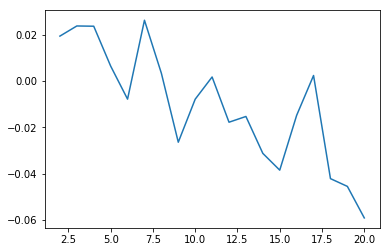

In [48]:
plt.plot(ks, sil)

In [46]:
best_k = ks[np.argmax(sil)]

In [47]:
print(best_k)

7


In [ ]:
kmeans = KMeans(n_clusters = best_k, max_iter = 10000).fit(documents)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

#### Don't UNDERSTAND what it is asking us to do ######

#### (B) Term-wise Clustering

In [49]:
words = np.load('science2k-word-doc.npy')

In [50]:
words.shape

(5476, 1373)

In [51]:
sil = []
ks = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters = k, max_iter = 10000).fit(words)
    labels = kmeans.labels_
    
    # determine whether the documents are labeled correctly
    sil.append(silhouette_score(words, labels, metric = 'euclidean'))

    ks.append(k)

KeyboardInterrupt: 

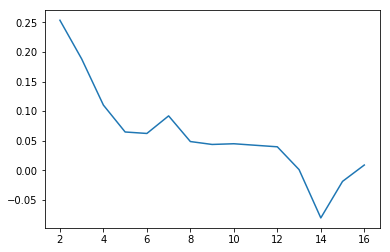

In [52]:
plt.plot(ks, sil)

In [53]:
best_k = ks[np.argmax(sil)]

In [54]:
print(best_k)

2


In [ ]:
kmeans = KMeans(n_clusters = best_k, max_iter = 10000).fit(words)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

#### Don't UNDERSTAND what it is asking us to do ######

# EM Algorithm and Implementation

In [ ]:
# Not actually run yet, have not idea if it works
with open('faitful.dat.txt') as f:
    df = pd.DataFrame()
    data = False
    for line in f:
        if data = False:
            if line = '    eruptions waiting\n':
                data = True
        else:
            # do something to turn put the data in the dataframe